In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from os import listdir
from os.path import splitext
import ipywidgets as widgets
from IPython.display import display
from dependencies import auto_correlation, cross_correlation, matrix_multiplication
from numpy import transpose, array, zeros, arange, absolute, pi, cos, sin, log10, sqrt, square as sqr, linspace, transpose
from numpy.linalg import inv as invers_matrix
from pandas import DataFrame
from scipy.io import wavfile
%matplotlib widget

In [2]:
def on_button_audio_clicked(change):
      with out_2:
            global audio0
            
            file = select_audio.get_interact_value()
            if (splitext(file)[1] == ".txt"):
                  with open(file, "r") as audio:
                        text_file = audio.readlines()
                  try:
                        temp = array([(x.replace("\n", "")).split() for x in text_file])
                        audio0 = DataFrame(temp, columns=["sequence", "amplitude"])
                        audio0 = audio0.astype(float)
                  except ValueError:
                        print("Please select double column text file. File Read Error!")
                        return      
            elif (splitext(file)[1] == ".wav"):
                  samplerate, data = wavfile.read(file)
                  length = data.shape[0] / samplerate
                  time = linspace(0., length, data.shape[0])
                  temp = array(transpose([time, data[:, 0]]))
                  audio0 = DataFrame(temp, columns=["sequence", "amplitude"])
                  audio0 = audio0.astype(float)
                  
            
            fig0_ax0.clear()
            print(audio0.dtypes)
            audio0["amplitude"].plot(ax=fig0_ax0, xlabel="sequence", ylabel="amplitude")
            audio_length.value = f"{len(audio0)}"
            print('Success!')

Output()

C:\Program Files\Python310\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  self.figure.savefig(buf, format='png', dpi='figure')


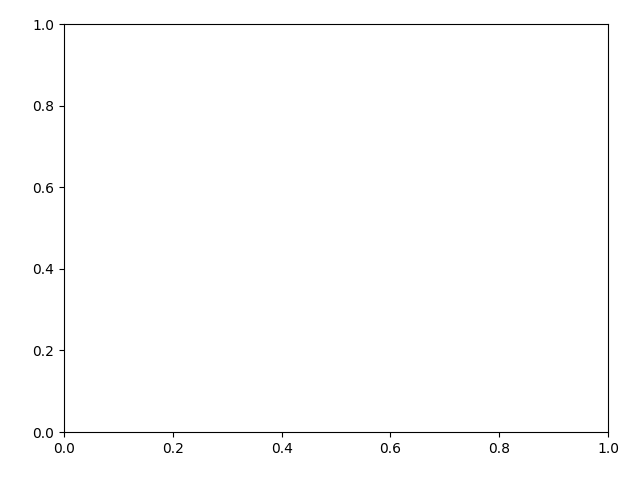

In [3]:
audio0 = [] # X(sequence) and Y(ecg signal) value

files = listdir(Path().absolute())
temp = []
for file in files:
    if (splitext(file)[1] == ".txt") or (splitext(file)[1] == ".wav"):
        temp.append(file)
files = temp

select_audio = widgets.Select(
    options=files,
    description='Select Audio:',
    disabled=False
)
audio_length = widgets.Text(value='0', disabled=True)
button_audio = widgets.Button(description='Select Audio')
button_audio.on_click(on_button_audio_clicked)

out_1 = widgets.Output()
with out_1:
    print("Please select only audio wav or txt extension from menu")
out_2 = widgets.Output()
out_3 = widgets.Output()
with out_3:
    fig0 = plt.figure(constrained_layout=True)
    fig0_ax0 = fig0.add_axes([0.1,0.1,0.85,0.85])

vertical_box_1 = widgets.VBox([select_audio, audio_length, button_audio, out_2])
horizontal_box_1 = widgets.HBox([vertical_box_1, out_3])
display(out_1, horizontal_box_1)

Output()

C:\Program Files\Python310\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  self.figure.savefig(buf, format='png', dpi='figure')


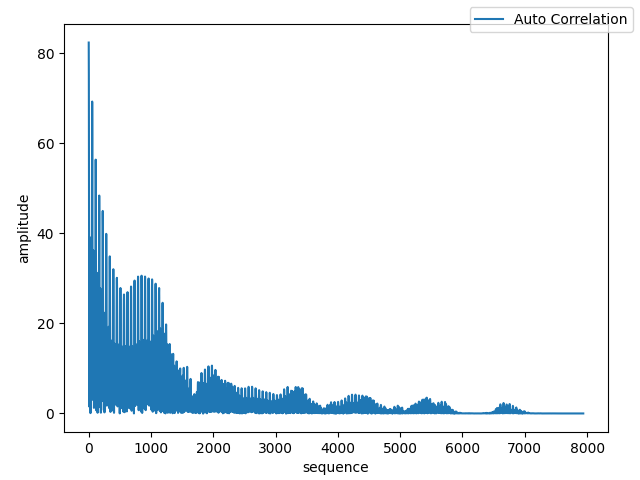

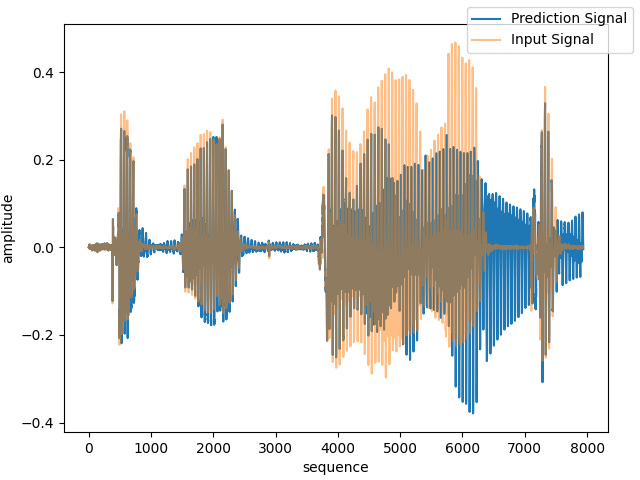

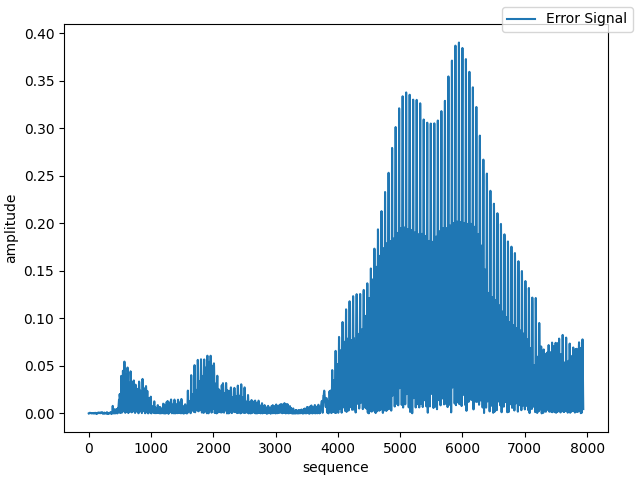

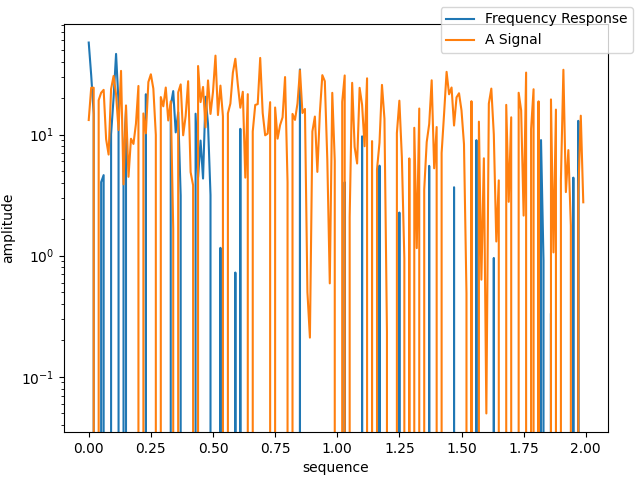

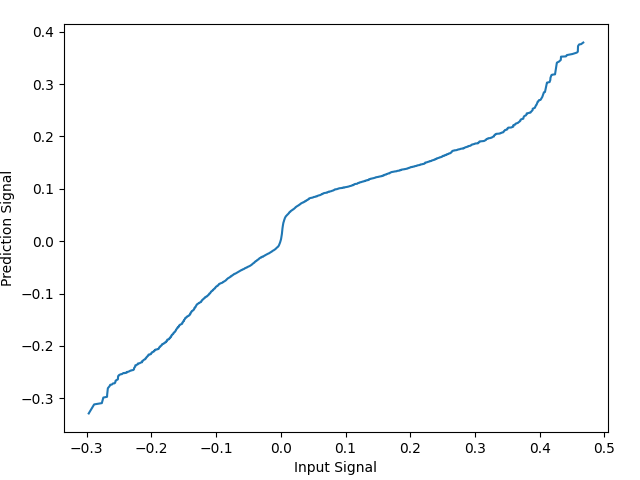

In [10]:
p = len(audio0["amplitude"])
# p = 10
# audio_auto_correlation = absolute(auto_correlation("normal", audio0["amplitude"]))
# p = 100
audio_auto_correlation = absolute(auto_correlation("timelag", audio0["amplitude"], timelag = p))
rxx_matrix = zeros((p-1, p-1))

for i in range(p-1):
    j = 0
    for k in range(i, 0, -1):
        rxx_matrix[i][j] = audio_auto_correlation[k]
        j += 1
    for l in range(0, p-1-i, 1):
        rxx_matrix[i][j] = audio_auto_correlation[l]
        j += 1
        
invers_rxx_matrix = invers_matrix(rxx_matrix)
coefficient_predictor = matrix_multiplication(invers_rxx_matrix, audio_auto_correlation[1:])
exitator_signal = zeros((len(audio0["amplitude"])))
error_model = zeros((len(audio0["amplitude"])))

for i in range(len(audio0["amplitude"])):
    exitator_signal[i] = audio0["amplitude"][i]
    for j in range(0, p):
        if i < j:
            continue
        exitator_signal[i] -= audio_auto_correlation[j] * audio0["amplitude"][i - j] / 3500
        
for i in range(len(exitator_signal)):
    error_model[i] = abs(audio0["amplitude"][i] - exitator_signal[i])

frequency_response = zeros(round(pi*100))
a_signal = zeros(round(pi*100))

for i in range(round(pi*100)):
    re = 0
    im = 0    
    omega = i/100
    for j in range(0, p-1):
        re += coefficient_predictor[j] * cos((j+1)*omega)
        im -= coefficient_predictor[j] * sin((j+1)*omega)
    frequency_response[i] = 20 * log10(1 / sqrt(sqr(1 - re) + sqr(im)))
    a_signal[i] = 20 * log10(sqrt(sqr(1 - re) + sqr(im)))
    
out_4 = widgets.Output()
with out_4:
    fig1 = plt.figure(constrained_layout=True)
    fig1_ax0 = fig1.add_axes([0.1,0.1,0.85,0.85], xlabel="sequence", ylabel="amplitude")
    fig1_ax0.plot(arange(len(audio_auto_correlation)), audio_auto_correlation, label="Auto Correlation")
    fig1.legend()
    

out_5 = widgets.Output()
with out_5:
    fig2 = plt.figure(constrained_layout=True)
    fig2_ax0 = fig2.add_axes([0.1,0.1,0.85,0.85], xlabel="sequence", ylabel="amplitude")
    fig2_ax0.plot(arange(len(exitator_signal)), exitator_signal, label="Prediction Signal")
    audio0["amplitude"].plot(ax=fig2_ax0, xlabel="sequence", ylabel="amplitude", label="Input Signal", alpha=0.5)
    fig2.legend()
    
out_6 = widgets.Output()
with out_6:
    fig3 = plt.figure(constrained_layout=True)
    fig3_ax0 = fig3.add_axes([0.1,0.1,0.85,0.85], xlabel="sequence", ylabel="amplitude")
    fig3_ax0.plot(arange(len(error_model)), error_model, label="Error Signal")
    fig3.legend()
    
out_7 = widgets.Output()
with out_7:
    fig4 = plt.figure(constrained_layout=True)
    fig4_ax0 = fig4.add_axes([0.1,0.1,0.85,0.85], xlabel="sequence", ylabel="amplitude", yscale="log")
    fig4_ax0.plot([x/100 for x in arange(len(frequency_response))][:200], frequency_response[:200], label="Frequency Response")
    fig4_ax0.plot([x/100 for x in arange(len(a_signal))][:200], a_signal[82:282], label="A Signal")
    fig4.legend()

out_8 = widgets.Output()
with out_8:
    fig5 = plt.figure(constrained_layout=True)
    fig5_ax0 = fig5.add_axes([0.1,0.1,0.85,0.85], xlabel="Input Signal", ylabel="Prediction Signal")
    fig5_ax0.plot(sorted(audio0["amplitude"]), sorted([-x for x in exitator_signal]))

horizontal_box_2 = widgets.HBox([out_4, out_5])
horizontal_box_3 = widgets.HBox([out_6, out_7])
display(horizontal_box_2, horizontal_box_3, out_8)

In [13]:
from scipy.io.wavfile import write
file = select_audio.get_interact_value()
samplerate, data = wavfile.read(file)
write("example.wav", samplerate, exitator_signal)

C:\Users\BAKARB~1\AppData\Local\Temp/ipykernel_2508/3407389560.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(file)
